# main

I'm trying to verify a linear profile is achieved when two parallel walls move relative to one another, thus shearing the fluid. Following [Couette](https://en.wikipedia.org/wiki/Couette_flow), this should happen.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
dir = '../data.lbm/'
# dir = '../src/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

101

# Fluid

In [4]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[-1]}.csv").set_index(["id_x","id_y"]).sort_index()

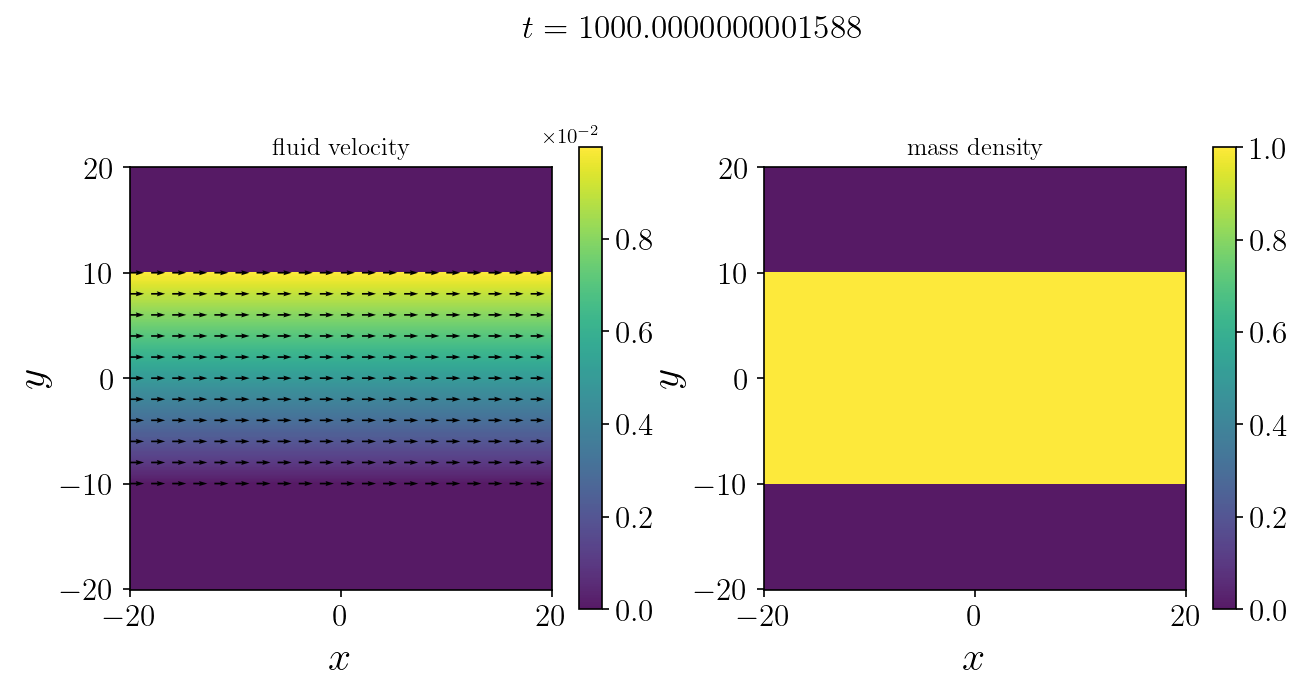

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Add a title for the whole figure
fig.suptitle(f"$t = {fluidDf.time.values[0]}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = fluidDf['coordinate_x'].unique()
y_unique = fluidDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

c = axes[0].pcolormesh(X, Y,
    np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[0].set_title('fluid velocity')

maskStep = int(len(x_unique)/20)
# Create a mask for filtering
mask = (fluidDf['coordinate_x'].isin(x_unique[::maskStep])) & (fluidDf['coordinate_y'].isin(y_unique[::maskStep])) & (
    (fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2 > 1e-16)
)
# Filter the DataFrame
filtered_df = fluidDf[mask]

axes[0].quiver(
    filtered_df['coordinate_x'], 
    filtered_df['coordinate_y'], 
    (filtered_df.fluidVelocity_x / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    (filtered_df.fluidVelocity_y / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    scale = 30,
)

c = axes[1].pcolormesh(X,Y,
    fluidDf.massDensity.unstack().values.transpose(),
#     vmin=min(fluidDf.query("massDensity > 0").massDensity.values),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[1].set_title('mass density')

for i in range(len(axes)):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

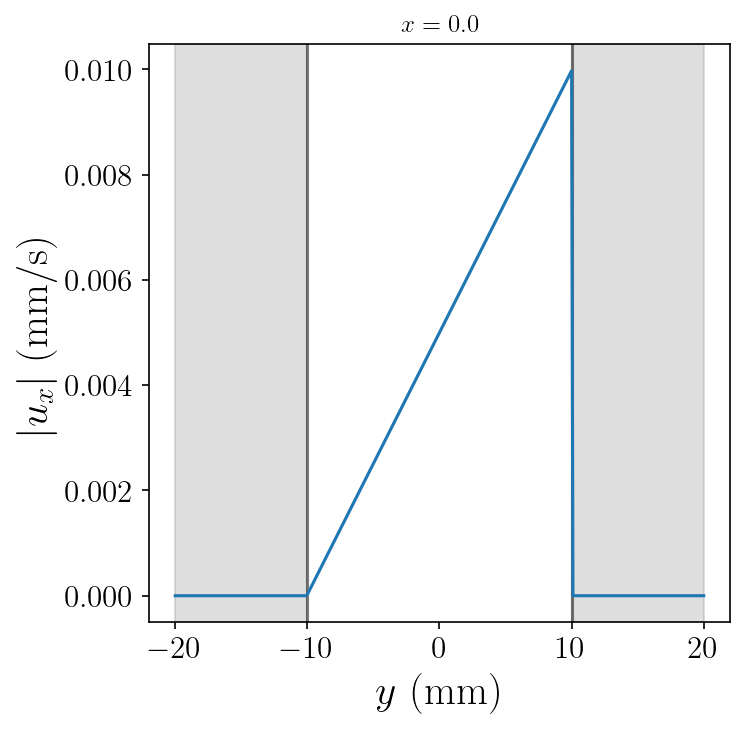

In [6]:
id = fluidDf.query("coordinate_x >= 0").reset_index().iloc[0].filter(["id_x"]).values[0]
v_x = fluidDf.loc[id].filter(["coordinate_y", "fluidVelocity_x"])

fig, ax = plt.subplots(figsize = (5,5))

ax.axvline(-10, color = "k", alpha = 0.5)
ax.axvline(10, color = "k", alpha = 0.5)
ax.axvspan(-20, -10, color='gray', alpha=0.25)  # Shade the wall
ax.axvspan(20, 10, color='gray', alpha=0.25)  # Shade the wall

ax.plot(v_x.coordinate_y, v_x.fluidVelocity_x) 
ax.set_xlabel("$y$ (mm)")
ax.set_ylabel("$|u_x|$ (mm/s)")
ax.set_title(f"$x = {fluidDf.query(f"id_x == {id}").iloc[0].filter(["coordinate_x"]).values[0]}$")
# ax.legend(loc='upper right')

plt.show()

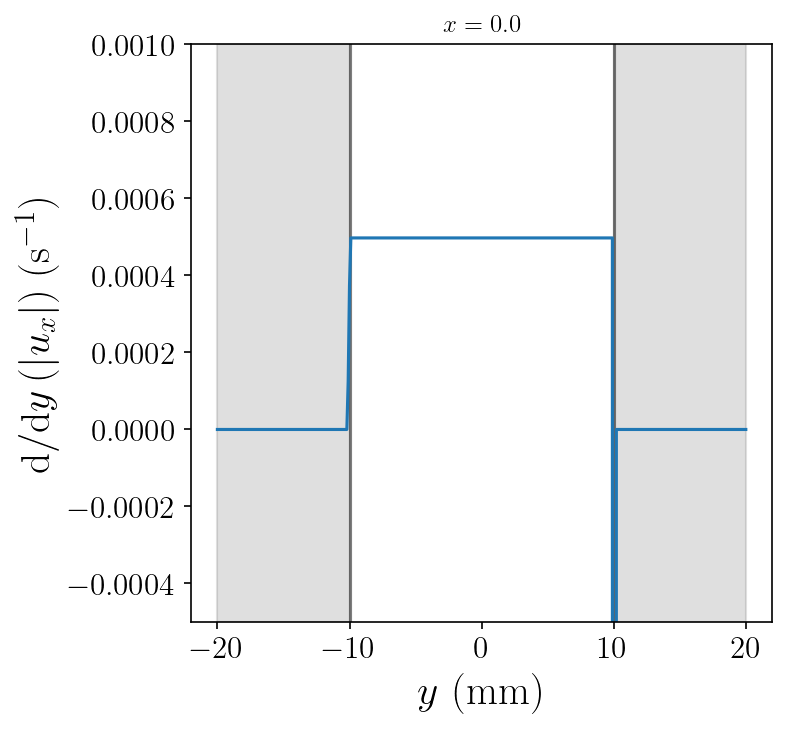

In [11]:
# id = fluidDf.query("coordinate_x >= 0").reset_index().iloc[0].filter(["id_x"]).values[0]
h = v_x.coordinate_y.values[1] - v_x.coordinate_y.values[0]
v_x['dVx_dy'] = np.gradient(v_x['fluidVelocity_x'], h)

fig, ax = plt.subplots(figsize = (5,5))

ax.axvline(-10, color = "k", alpha = 0.5)
ax.axvline(10, color = "k", alpha = 0.5)
ax.axvspan(-20, -10, color='gray', alpha=0.25)  # Shade the wall
ax.axvspan(20, 10, color='gray', alpha=0.25)  # Shade the wall

ax.plot(v_x.coordinate_y, v_x.dVx_dy) 
ax.set_xlabel("$y$ (mm)")
ax.set_ylabel("$\\mathrm{d}/\\mathrm{d}y \\left(|u_x|\\right)$ (s$^{-1}$)")
ax.set_ylim([-0.5e-3, 1e-3])
ax.set_title(f"$x = {fluidDf.query(f"id_x == {id}").iloc[0].filter(["coordinate_x"]).values[0]}$")
# ax.legend(loc='upper right')

plt.show()

In [8]:
def maxSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).max()

maximumFluidSpeed = [
    maxSpeed(pd.read_csv(dir + f"fluidTrj_{tick}.csv"))
for tick in ticks]
time = [pd.read_csv(dir + f"fluidTrj_{tick}.csv").time.values[0] for tick in ticks]

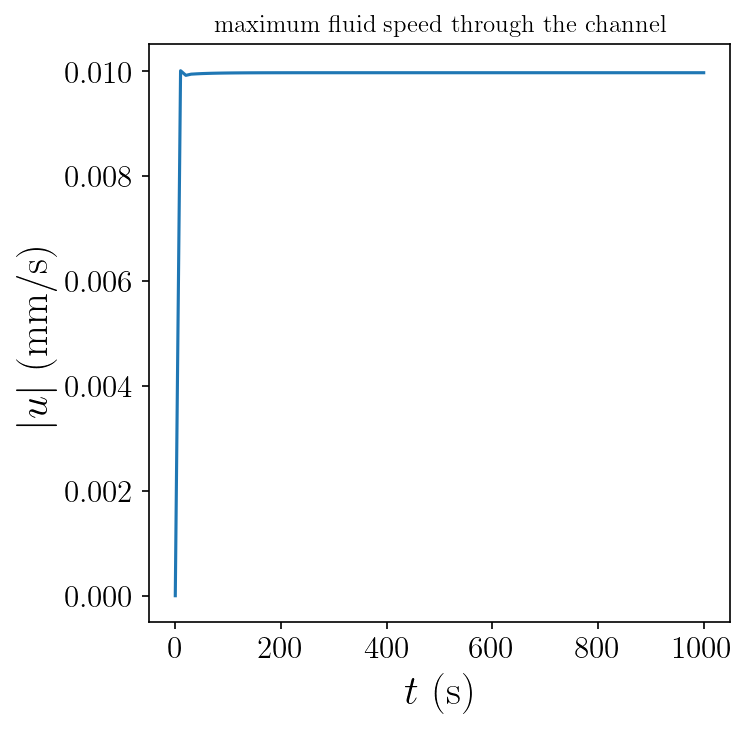

In [9]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, maximumFluidSpeed)
ax.set_title("maximum fluid speed through the channel")
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("$|u|$ (mm/s)")

plt.show()

# Stress tensor

In [12]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

tick    time  coordinate_x  coordinate_y  component_xx  \
id_x id_y                                                            
1    1     10000  1000.0         -20.0         -20.0          -0.0   
     2     10000  1000.0         -20.0         -19.9          -0.0   
     3     10000  1000.0         -20.0         -19.8          -0.0   
     4     10000  1000.0         -20.0         -19.7          -0.0   
     5     10000  1000.0         -20.0         -19.6          -0.0   
...          ...     ...           ...           ...           ...   
401  397   10000  1000.0          20.0          19.6          -0.0   
     398   10000  1000.0          20.0          19.7          -0.0   
     399   10000  1000.0          20.0          19.8          -0.0   
     400   10000  1000.0          20.0          19.9          -0.0   
     401   10000  1000.0          20.0          20.0          -0.0   

           component_yx  component_xy  component_yy  
id_x id_y                                            
1    1             -0.0          -0.0          -0.0  
     2             -0.0          -0.0          -0.0  
     3             -0.0          -0.0          -0.0  
     4             -0.0          -0.0          -0.0  
     5             -0.0          -0.0          -0.0  
...                 ...           ...           ...  
401  397           -0.0          -0.0          -0.0  
     398           -0.0          -0.0          -0.0  
     399           -0.0          -0.0          -0.0  
     400           -0.0          -0.0          -0.0  
     401           -0.0          -0.0          -0.0  

[160801 rows x 8 columns]

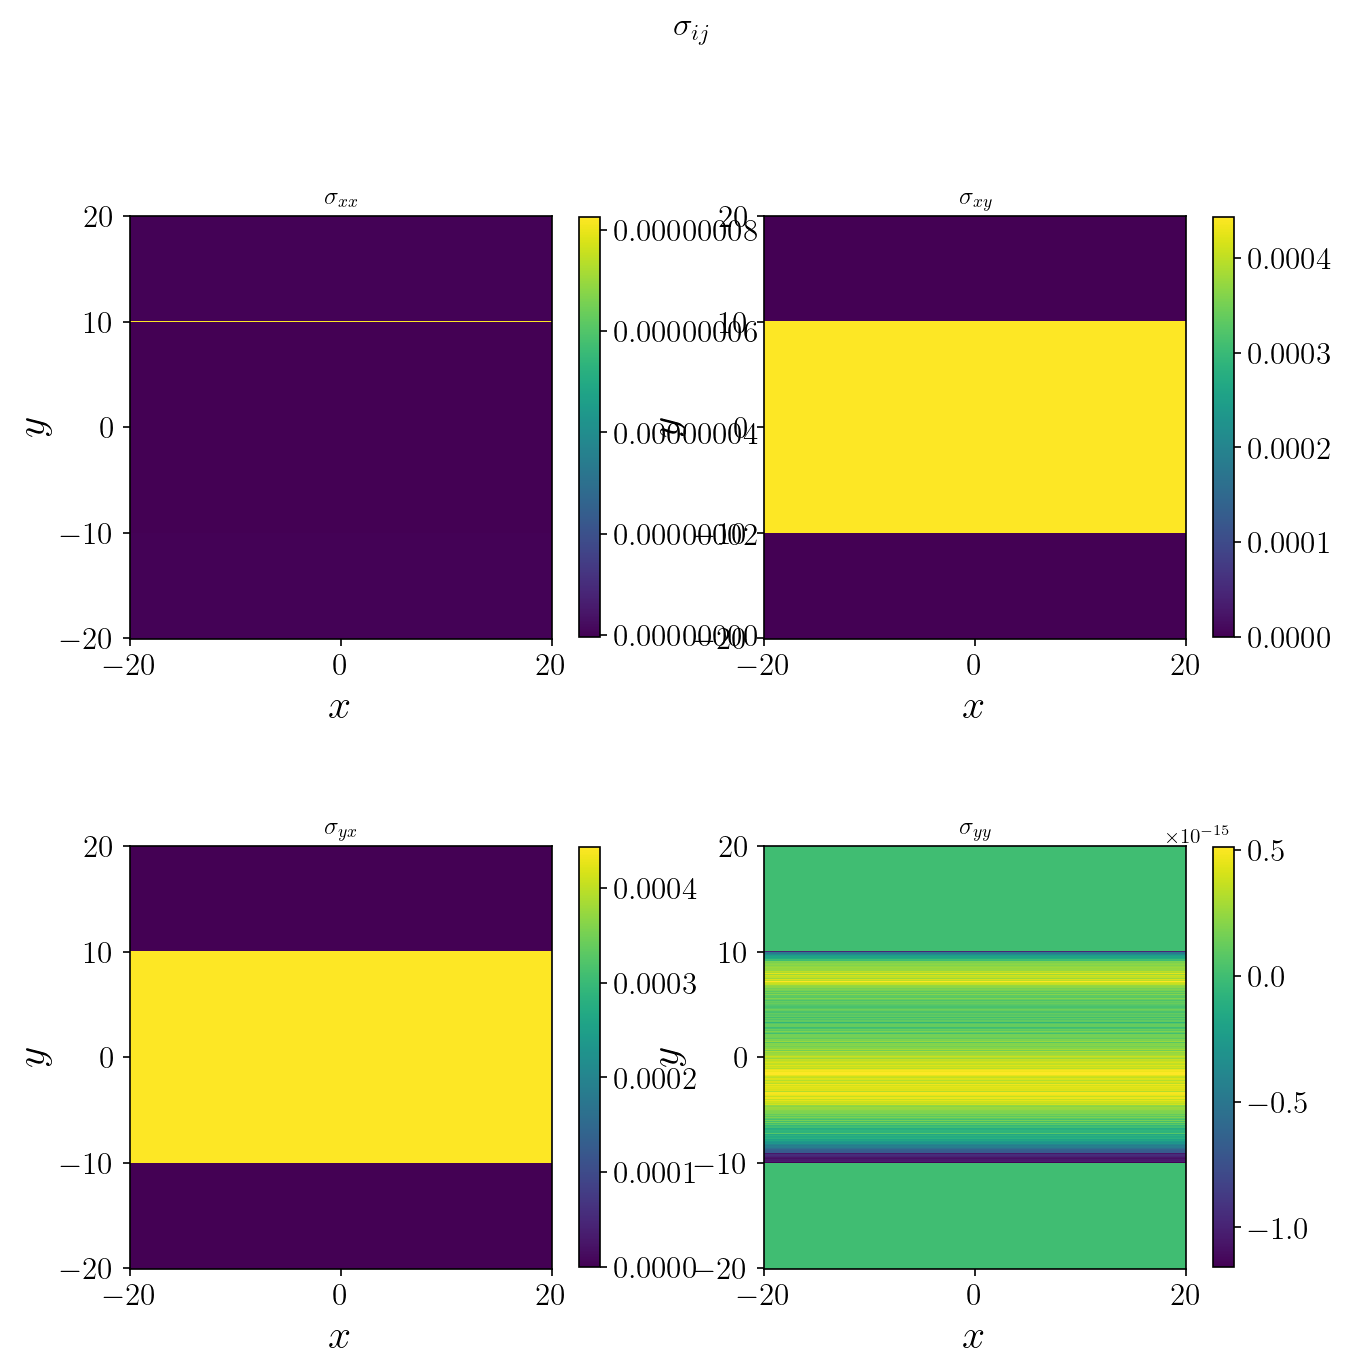

In [13]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()